# TP1

In [2]:
import numpy as np
import pandas as pd
import pydotplus
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from IPython.display import display
from sklearn import preprocessing
from sklearn.externals.six import StringIO  
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split

## Lectura del dataset

Se reemplaza el atributo "Data of birth" por "Age", encodeamos "Social Class". También encodeamos "Presence of Children" para que tome 2 valores: 0 si no hay hijos, 1 en caso contrario

In [3]:
def readCsv():
    df = pd.read_csv("FullData2.csv")
    
    #Agregamos atributo edad
    df['Date of birth'] = pd.to_datetime('today').year - pd.to_datetime(df['Date of birth'],format='%Y-%m-%d').dt.year
    df = df.rename(columns={'Date of birth': 'Age' })
    
    #Encode social class
    socialClassEncoder = preprocessing.LabelEncoder()
    socialClassEncoder.fit(["AB", "C1", "C2", "D ", "E "])
    
    df['Social Class'] = socialClassEncoder.transform(df['Social Class'])
    
    #Agrupamos en 2 clases "Presence of Children"
    df['Presence of Children'] = df['Presence of Children'].apply(lambda x: 1 if x > 1 else 0)
    
    return df

df = readCsv()

## 1. Partición de datos 

Particionamos el conjunto entre datos de entramiento y de test. Los de validación se van a ir generando en cada uno de los k-folds. 

In [4]:
def partitionate(df):
    #Seteamos Presence of Children como target
    targetColumn = "Presence of Children"
    
    #El resto de las columnas las vamos a usar como feature para clasificar
    features = list(df.columns)
    features.remove(targetColumn)
    
    #Eliminamos otras columnas que están muy relacionadas con lo que queremos predecir (deberíamos sacarlas del csv)
    features.remove("Demographic cell 1")
    features.remove("Mosaic Classification")
    features.remove("Life stage")
    features.remove("No of People")
    features.remove("Age")
    features.remove("Terminal age of education")

    return train_test_split(df[features], df[targetColumn], train_size=0.8, test_size=0.2, random_state=42)

X, test_X, y, test_y = partitionate(df)

## 3. Naive Bayes

Ejecutar Naive Bayes, informar las probabilidades condicionales y previas. Realizar
las validaciones correspondientes


In [5]:
# se instancia el modelo
model = GaussianNB()
model.fit(X,y)
    
# se hacen las predicciones sobre test y train
predict_train=model.predict(X)
predict_test=model.predict(test_X)

print('accuracy en train:  ',round(accuracy_score(y, predict_train),2)*100,'%')
print('accuracy en test :  ',round(accuracy_score(test_y, predict_test), 2)*100,'%')

accuracy en train:   66.0 %
accuracy en test :   65.0 %


In [6]:
# la distribución en train es:
round(y.value_counts()/len(y)*100,1)

0    62.3
1    37.7
Name: Presence of Children, dtype: float64

Es decir que la distribución de la base en train es 62.3% de las personas censadas no tienen hijos. El modelo NB propuesto logra mejorar el azar en poco más del 2.7%.

In [11]:
#p_cero=[round(model.predict_proba(test_X)[i][0]*100,2) for i in range(len(model.predict_proba(test_X)))]
#p_uno=[round(model.predict_proba(test_X)[i][1]*100,2) for i in range(len(model.predict_proba(test_X)))]
d={'P(0)/xi':p_cero,'P(1)/xi':p_uno}
proba=pd.DataFrame(data=d)
proba

,P(0)/xi,P(1)/xi
0,7.5,92.5
1,100.0,0.0
2,0.1,99.9
3,100.0,0.0
4,1.3,98.7
5,0.4,99.6
6,100.0,0.0
7,0.1,99.9
8,80.2,19.8
9,100.0,0.0


In [8]:
# se evalua la diferencia que hay entre las probabilidades condicionales asignadas para cada registro. 
diferencia=[model.predict_proba(test_X)[i][0]-model.predict_proba(test_X)[i][1] for i in range(len(model.predict_proba(test_X)))]

Se grafica diferencia para observar casos donde la diferencia se menor a un determinado umbral. Diferencias entre -0.2 y 0.2 implique el modelo no logra diferenciar bien entre categorías

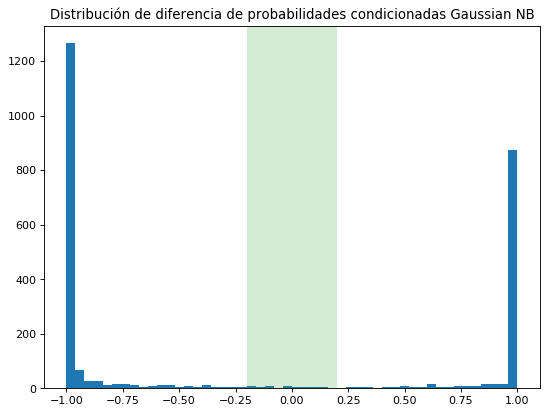

In [25]:
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Distribución de diferencia de probabilidades condicionadas Gaussian NB')
plt.hist(diferencia,bins=50)
plt.axvspan(-0.2,0.2, facecolor='#2ca02c', alpha=0.2)
plt.show()

In [14]:
len(df.columns)

52